In [1]:
import json
from PIL import Image
import matplotlib. pyplot as plt
import SimpleITK as sitk
import numpy as np
import scipy
import torch
import pandas as pd
import scipy.ndimage
from tqdm import tqdm

In [2]:
import os
from pytorch_pretrained_vit.model import ViT

In [3]:
label_path = "/home/jielian/lung-graph-project/data/seg_image/labels/"
stage1= list(np.load(label_path+"name_stage1.npy"))
stage2= list(np.load(label_path+"name_stage2.npy"))
stage3= list(np.load(label_path+"name_stage3.npy"))

In [4]:
stage12 = [*stage1, *stage2]
print(len(stage12))

1705


In [5]:
# step 0: Read Image and rescpacing
def read_image(path, tar_spacing=[1.0, 1.0, 1.0]):
    img = sitk.ReadImage(path)
  # size in x, y,z
    img.SetSpacing(tar_spacing)
    array_img = sitk.GetArrayFromImage(img)
    #array in z, y, x
    print("Original Shape:",array_img.shape)
    return array_img

# Step 1: Normilize the image
def normlize(array_img):
    ctoriTR = np.clip((array_img + 1000.)/(1000+1000),0,1000)
    return ctoriTR

# Step 2: Padding the image
def padding_Zero_3D(array_img, target_shape = (64, 218, 218)):
    img_shape= array_img.shape
    padded_array = np.zeros((target_shape))
    y = int((target_shape[1]-img_shape[1])/2)
    x = int((target_shape[2]-img_shape[2])/2)
    if img_shape[0] <= target_shape[0]:
        z = int((target_shape[0]-img_shape[0])/2)
        padded_array[z:img_shape[0]+z, y:img_shape[1]+y, x:img_shape[2]+x] = array_img
    else:
        padded_array[:, y:img_shape[1]+y, x:img_shape[2]+x] = array_img[img_shape[0]/2 -32, img_shape[0]/2 +32]
#     print("Array After Padding:", padded_array.shape)
    return padded_array

def padding_Zero_large_3D(array_img, target_shape = (64, 128, 128)):
    tz, ty, tx = target_shape[0], target_shape[1], target_shape[2]
    padded_array = np.zeros((target_shape))
    oz, oy, ox = array_img.shape
    interp = max(ox, oy)
#     print(interp)
    inter_pad = np.zeros((oz,interp , interp))
    if ox>= oy:
        inter_pad[:, int((interp-oy)/2): int((interp-oy)/2)+oy,  :]=array_img
    else: 
        inter_pad[:,:,int((interp-ox)/2): int((interp-ox)/2)+ox]=array_img

    if ty >= interp:
        x = int((tx-interp)/2)
        y = int((ty-interp)/2)
        if oz <= tz:
            z = int((tz-oz)/2)
            padded_array[z:oz+z, y:interp+y, x:interp+x] = inter_pad
        else:
            padded_array[:, y:interp+y, x:interp+x] = inter_pad[int(oz/2 -tz/2): int(oz/2+tz/2)]
    else:
        x = int(tx/2)
        y = int(ty/2)
        if oz <= tz:
            z = int((tz-oz)/2)
            padded_array[z:oz+z, :, :] = inter_pad[:, int(interp/2-y):int(interp/2+y), int(interp/2-x):int(interp/2+x)]
        else:
            padded_array[:, :, :] = inter_pad[int(oz/2 -tz/2):int(oz/2+tz/2), int(interp/2-y):int(interp/2+y), int(interp/2-x):int(interp/2+x)]
    return padded_array

# step 3 : Resize the image to 36*64*64    
def resize3D(img):
    dims, dimx, dimy = img.shape
    ns, nx, ny = 36,64,64
    rs, rx, ry = dims/ns,  dimx/nx,  dimy/ny  
    new_img = scipy.ndimage.zoom(img,(1/rs,1/rx,1/ry),order=1)
#     print("After Rsizing:", new_img.shape)
    return new_img

# Step 4: Flatten the 3D images to 2D images
def resize2D(img):
    new_im = np.zeros((384, 384))
    # slices number should be 36
    for i in range(6):
    # 2d with shape 64*64
        for j in range(6):
            new_im[i*64:i*64+64, j*64:j*64+64] = img[i*6+j]
    return new_im

def stander_3dImage(img_path):
    array_img = read_image(img_path)
    norm_img = normlize(array_img)
    pad_img = padding_Zero_3D(norm_img)
    new_img_3D = resize3D(pad_img)
    new_img_2D = resize2D(new_img_3D)
    return new_img_2D

def stander_3dImage_large_array(img_path):
#     array_img = read_image(img_path)
# #     print(np.mean(array_img))
    array_img = np.load(img_path,allow_pickle= True)
    norm_img = normlize(array_img)
#     print(np.mean(norm_img))
    pad_img = padding_Zero_large_3D(norm_img)
    new_img_3D = resize3D(pad_img)
    new_img_2D = resize2D(new_img_3D)
    return new_img_2D

def stander_3dImage_large(img_path):
    array_img = read_image(img_path)
#     print(np.mean(array_img))
    norm_img = normlize(array_img)
#     print(np.mean(norm_img))
    pad_img = padding_Zero_large_3D(norm_img)
    new_img_3D = resize3D(pad_img)
    new_img_2D = resize2D(new_img_3D)
    return new_img_2D

# Target size for images: torch.Size([1, 1, 384, 384])
def input_image(d2_image):
    # Image shpuld have a shape of 384*384
    # add a channel dim
    img = np.expand_dims(d2_image, axis=0)
    # add a batch dim
    img = np.expand_dims(img, axis=0)
    # To tensor
    img = torch.Tensor(img)
    return img

In [5]:
model_name = 'B_16_imagenet1k'
model = ViT(model_name, pretrained=True)

Loaded pretrained weights.


In [6]:
# for SHPH dataset
tumors_folder = '/home/jielian/lung-graph-project/data/seg_image/raw_seg/tumor/'
save_folder = '/home/jielian/lung-graph-project/Tumor_tranformer/trans_feature/'
model.eval()

for img_name in tqdm(stage3):
    try:
        img_path = tumors_folder+str(img_name)+'.nii'
        new2d = stander_3dImage_large(img_path)
        new2d_tensor = input_image(new2d)
        with torch.no_grad():
            outputs, feature = model(new2d_tensor)
            final_feature=feature.squeeze()
            save_name = save_folder + str(img_name) + ".npy"
            np.save(save_name, final_feature)
    except Exception as e:
        print(img_name)
        print(e)
    


100%|█████████████████████████████████████████| 420/420 [04:15<00:00,  1.65it/s]


In [ ]:
# for external validation
tumors_folder = '/home/jielian/lung-graph-project/data/seg_image/External/tumor/raw/'
save_folder = '/home/jielian/lung-graph-project/Tumor_tranformer/trans_feature_val/'
model.eval()
name_list = os.listdir(tumors_folder)

for img_name in tqdm(name_list):
    try:
        img_path = tumors_folder+img_name
        new2d = stander_3dImage_large_array(img_path)
        new2d_tensor = input_image(new2d)
        with torch.no_grad():
            outputs, feature = model(new2d_tensor)
            final_feature=feature.squeeze()
            save_name = save_folder + img_name
            np.save(save_name, final_feature)
    except Exception as e:
        print(img_name)
        print(e)
    

 70%|████████████████████████████▌            | 111/159 [00:30<00:11,  4.12it/s]

In [11]:
tumors_folder = '/home/jielian/lung-graph-project/data/seg_image/raw_seg/tumor/'
save_folder = 'inter_figures/'
name_list = os.listdir(tumors_folder)

In [14]:
iname = name_list[100]
img_path = tumors_folder+iname
print(img_path)
img1 = read_image(img_path) # raw image
norm_img = normlize(img1) # normolized image
new3d = resize3D(padding_Zero_large_3D(norm_img)) # padded image
new2d = stander_3dImage_large(img_path) # 2d image

/home/jielian/lung-graph-project/data/seg_image/raw_seg/tumor/365456.nii
Original Shape: (160, 106, 116)
Original Shape: (160, 106, 116)


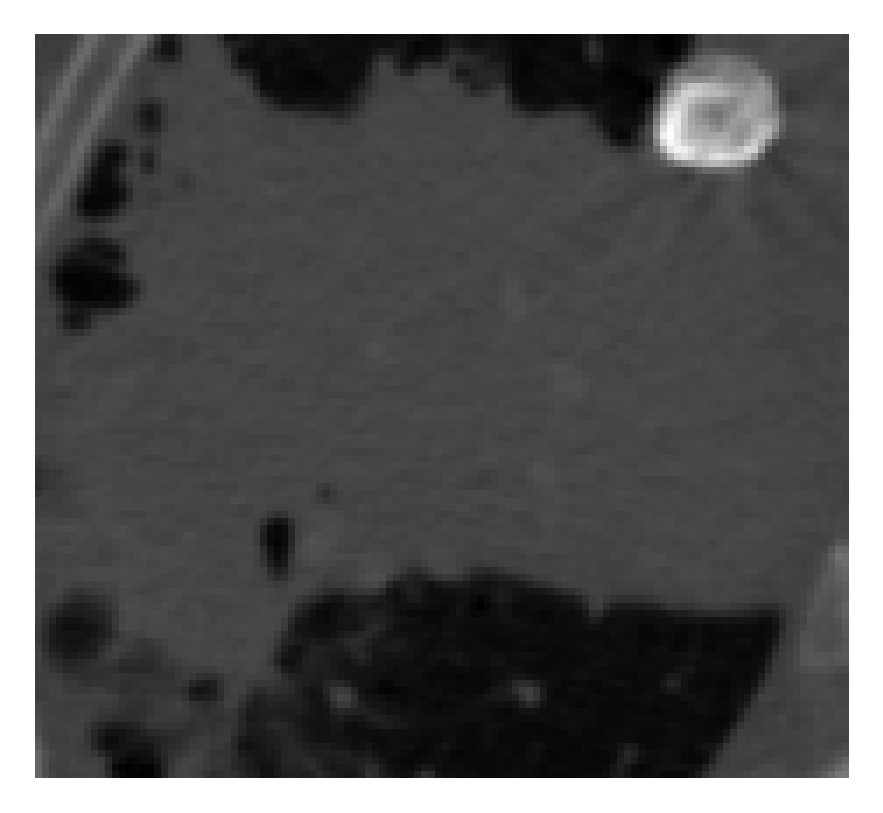

In [16]:
fig = plt.figure(figsize=(3,3), dpi =350)
plt.imshow(img1[80], cmap='gray')
plt.axis('off')
fig.savefig(save_folder+iname[:-4]+'_160106116_raw.png')

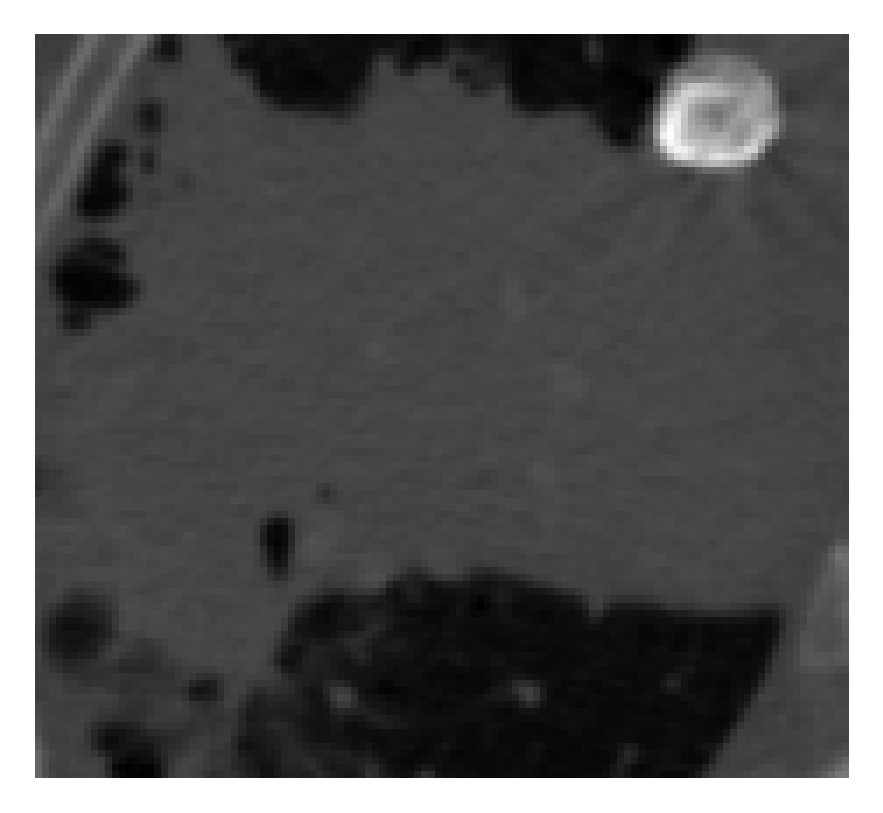

In [17]:
fig = plt.figure(figsize=(3,3), dpi =350)
plt.imshow(norm_img[80], cmap='gray')
plt.axis('off')
fig.savefig(save_folder+iname[:-4]+'_norm.png')

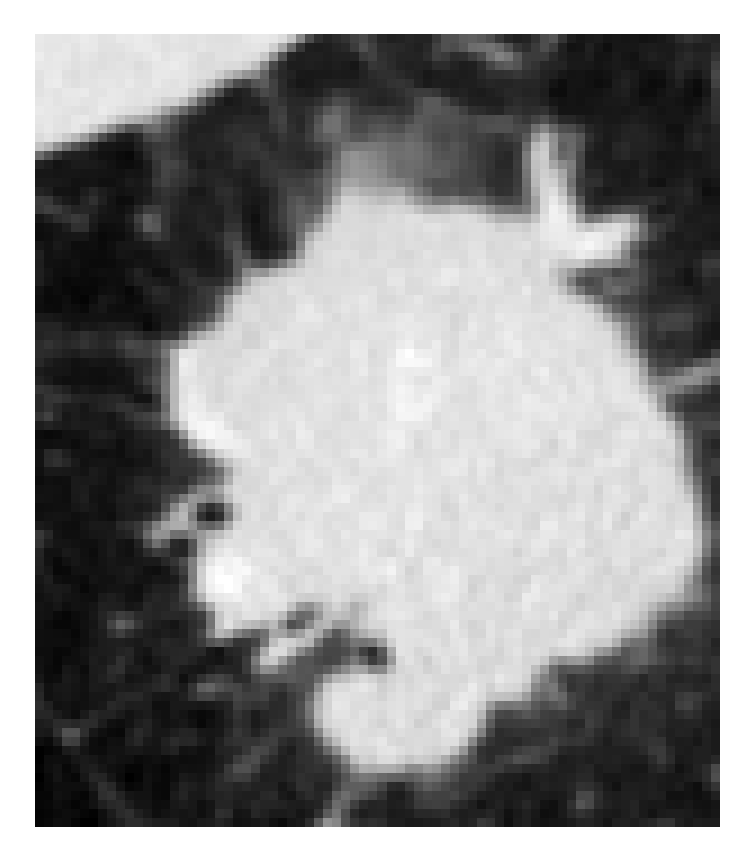

In [93]:
fig = plt.figure(figsize=(3,3), dpi =350)
plt.imshow(img1[:,:,50], cmap='gray')
plt.axis('off')
fig.savefig(save_folder+iname[:-4]+'_raw_x.png')

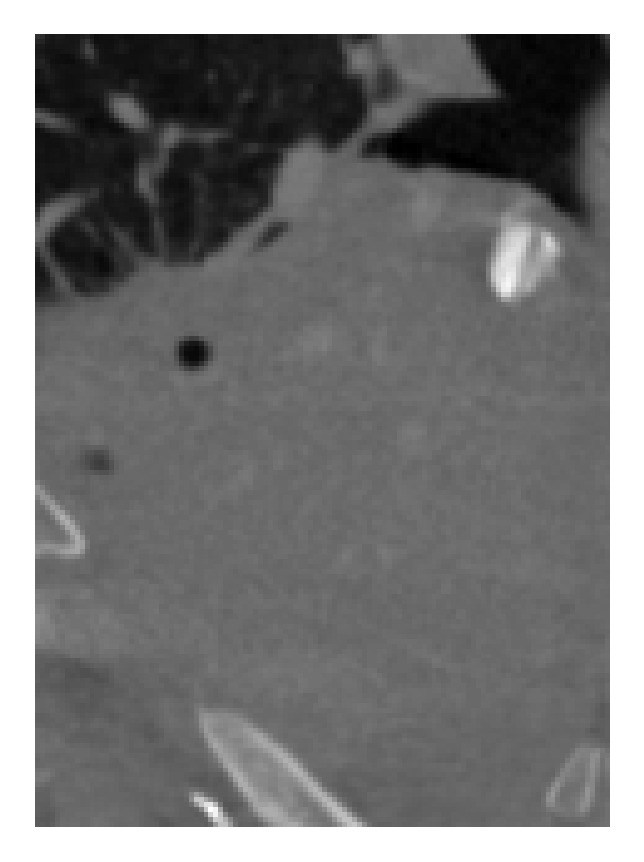

In [18]:
fig = plt.figure(figsize=(3,3), dpi =350)
plt.imshow(img1[:,50,:], cmap='gray')
plt.axis('off')
fig.savefig(save_folder+iname[:-4]+'_raw_y.png')

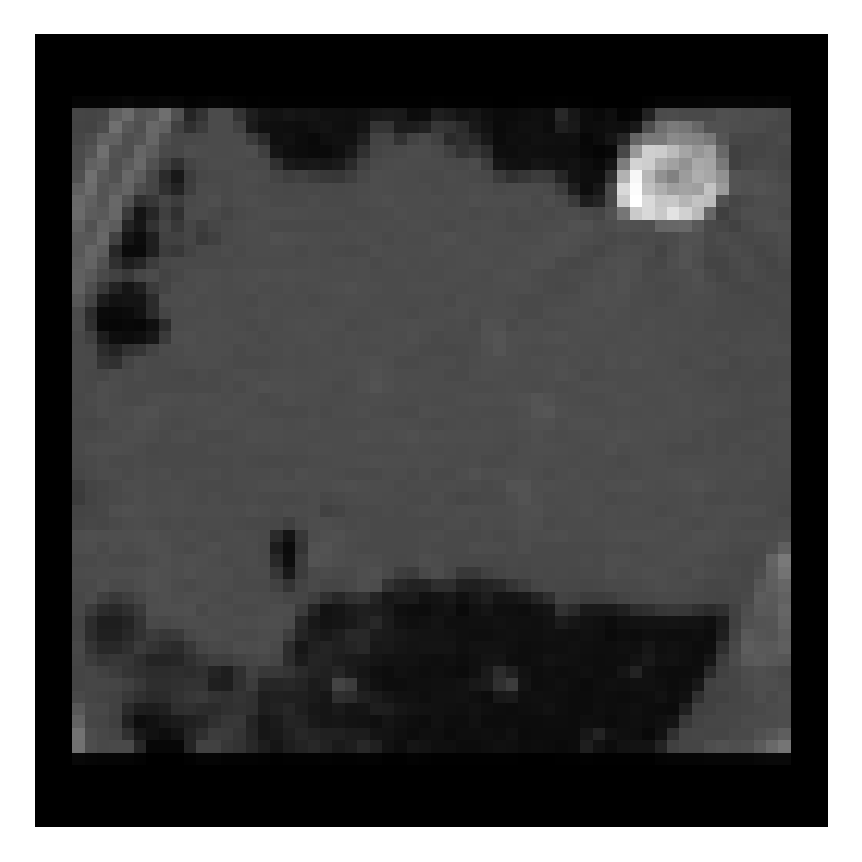

In [19]:
fig = plt.figure(figsize=(3,3), dpi =350)
plt.imshow(new3d[18], cmap='gray')
plt.axis('off')
fig.savefig(save_folder+iname[:-4]+'_padded.png')

/tmp/ipykernel_56251/1715076504.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(1,1), dpi =350)


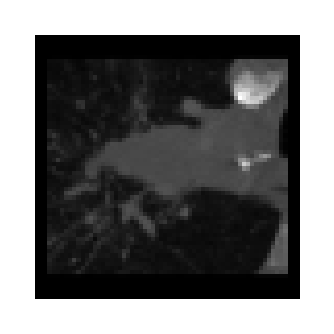

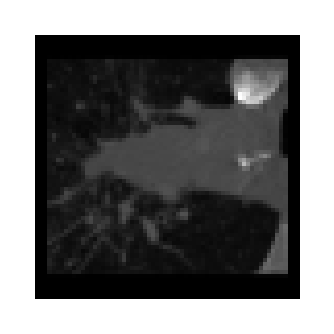

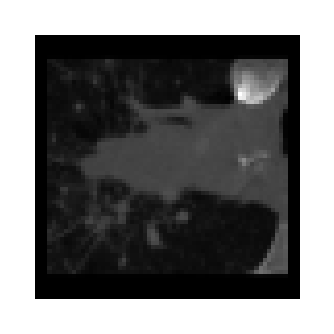

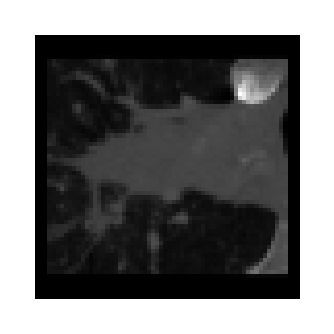

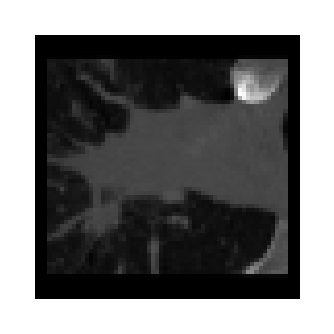

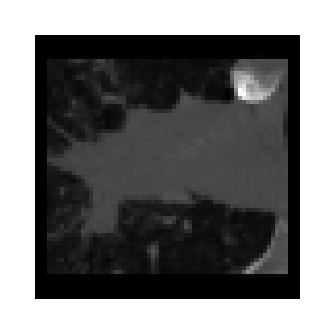

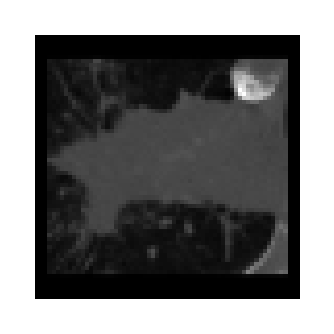

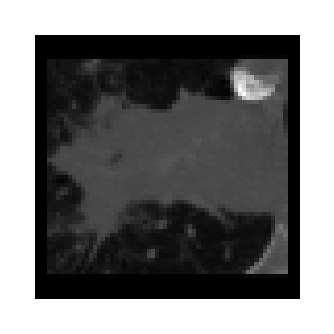

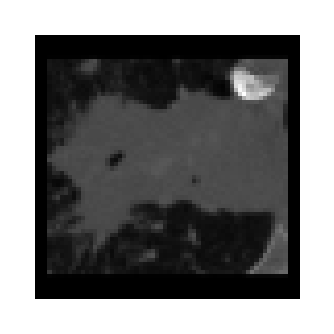

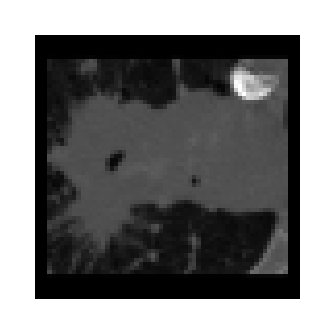

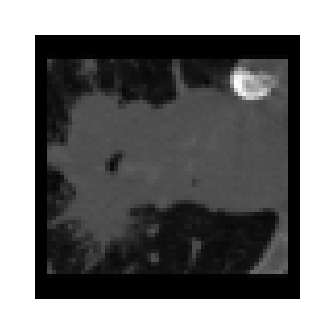

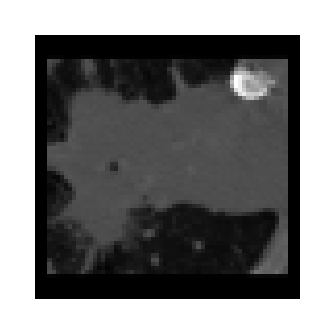

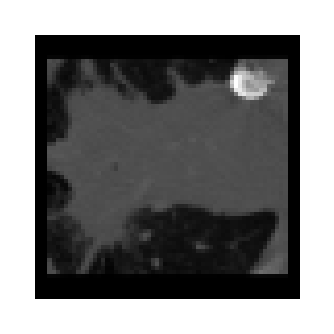

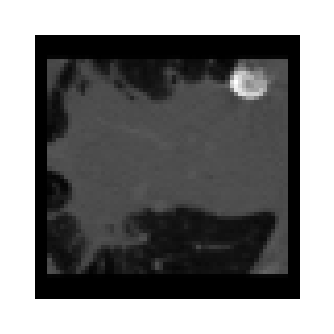

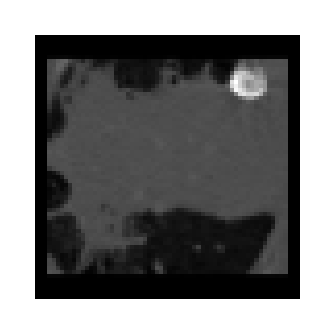

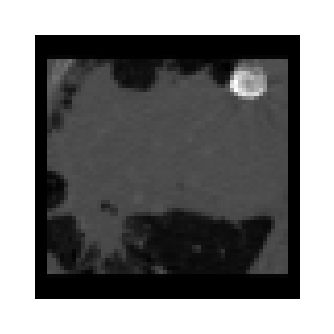

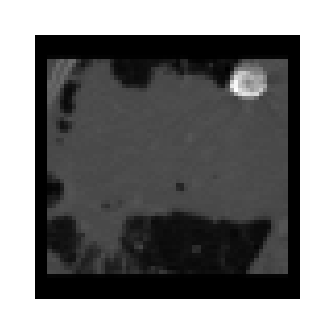

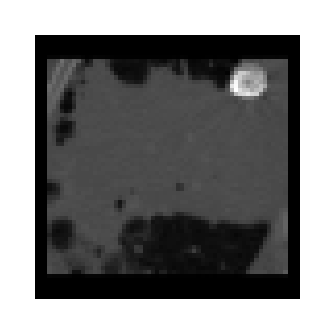

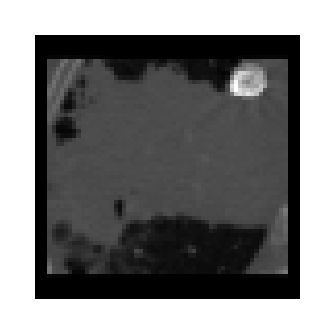

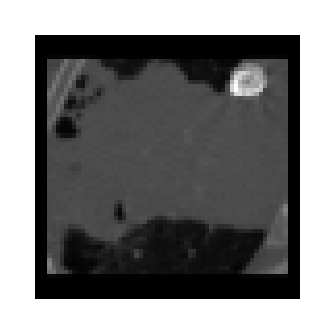

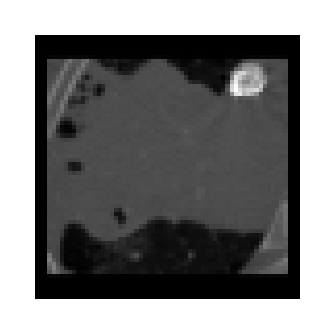

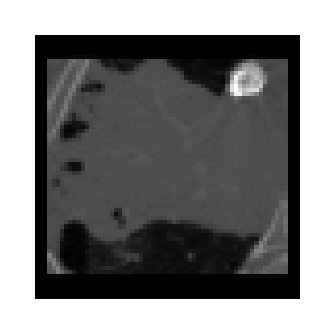

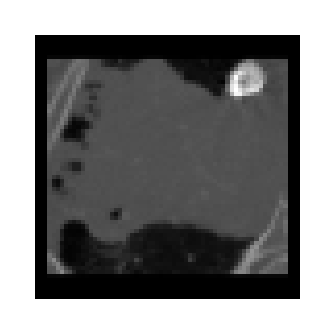

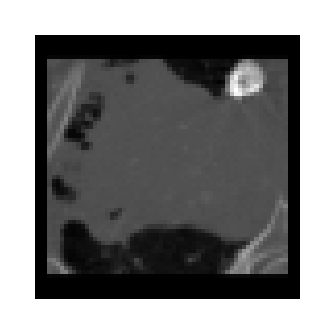

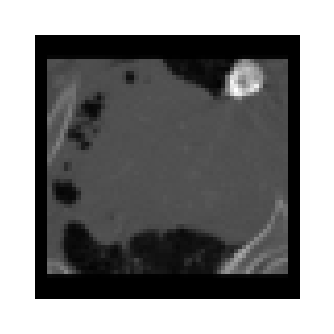

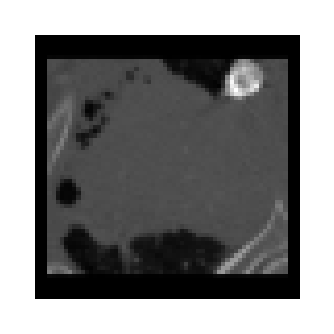

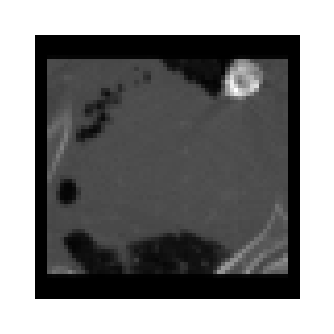

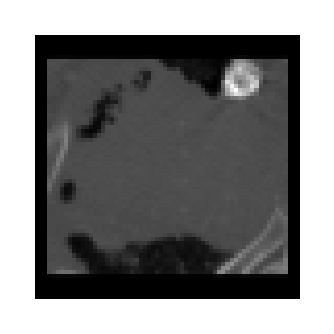

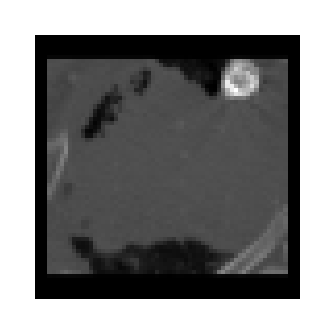

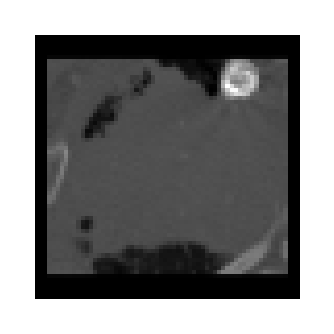

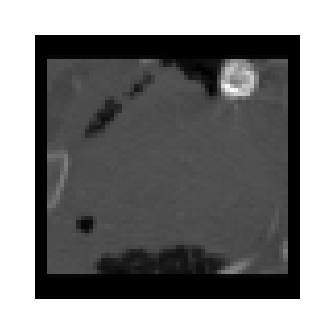

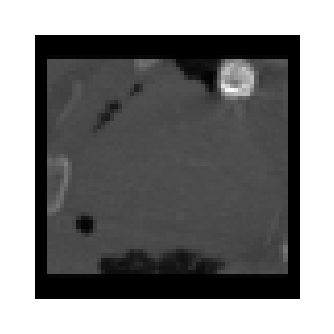

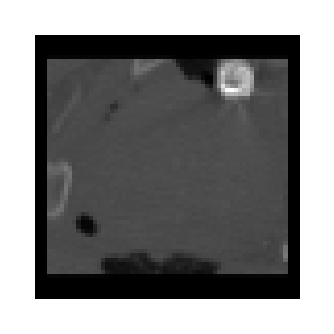

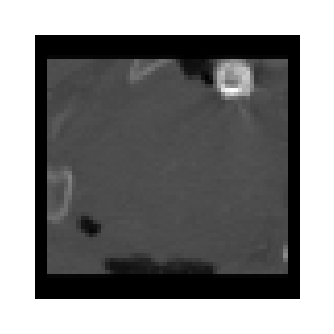

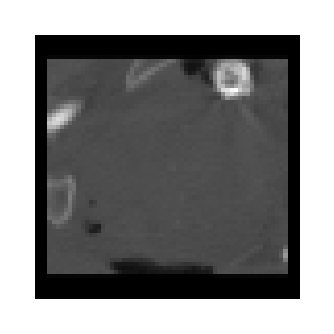

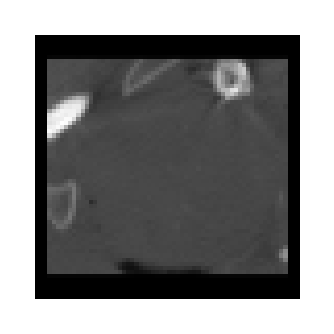

In [20]:
for i in range(6):
    # 2d with shape 64*64
        for j in range(6):
            pim= new2d[i*64:i*64+64, j*64:j*64+64]
            
            fig = plt.figure(figsize=(1,1), dpi =350)
            plt.imshow(pim, cmap='gray')
            plt.axis('off')
            fig.savefig(save_folder+iname[:-4]+str(i)+str(j)+'_2d.png')

NameError: name 'new2d1' is not defined

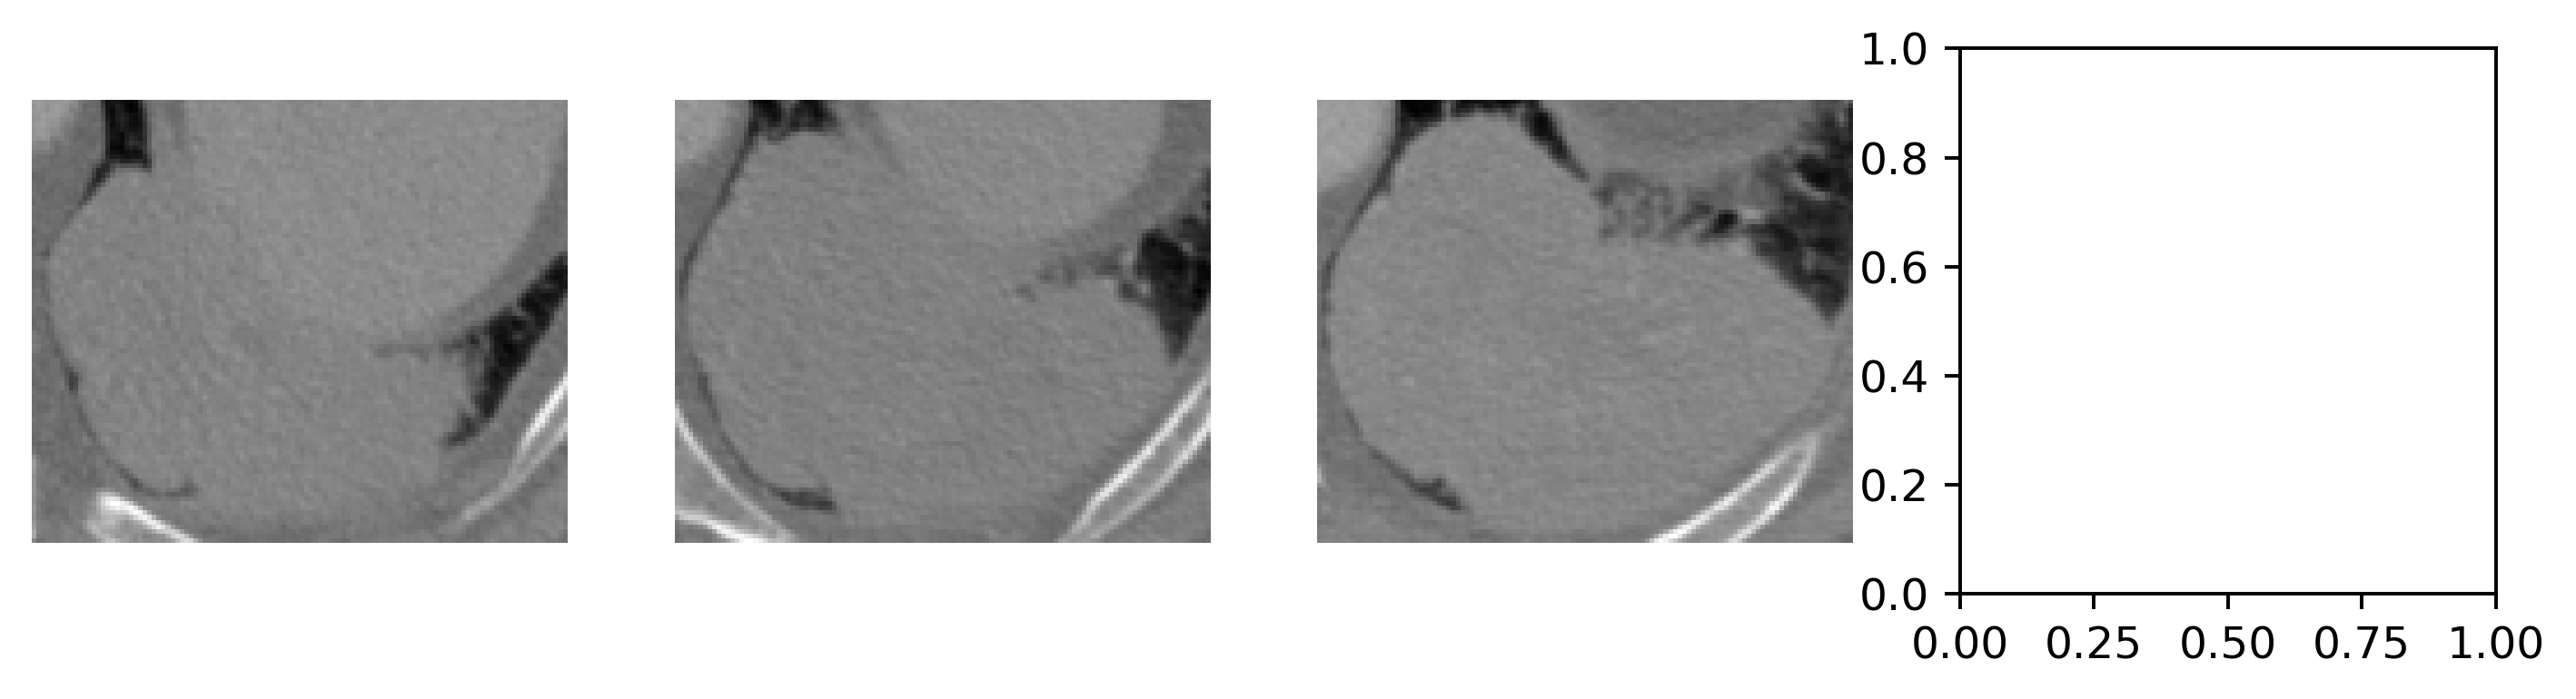

In [29]:
fig = plt.figure(figsize=(10,5), dpi =350)
ax1 = plt.subplot(2,4,1)
plt.axis('off')
plt.imshow(img1[20], cmap='gray') 

ax2 = plt.subplot(2,4,2)
plt.axis('off')
plt.imshow(img1[30], cmap='gray') 

ax3 = plt.subplot(2,4,3)
plt.imshow(img1[40], cmap='gray') 
plt.axis('off')

ax4 = plt.subplot(2,4,4)
plt.imshow(new2d1, cmap='gray') 
plt.axis('off')

ax5 = plt.subplot(2,4,5)
plt.axis('off')
plt.imshow(img2[20], cmap='gray') 

ax6 = plt.subplot(2,4,6)
plt.axis('off')
plt.imshow(img2[30], cmap='gray') 

ax7 = plt.subplot(2,4,7)
plt.imshow(img2[40], cmap='gray') 
plt.axis('off')

ax8 = plt.subplot(2,4,8)
plt.imshow(new2d2, cmap='gray') 
plt.axis('off')
fig.savefig("Figure_1A.jpg")